# Capstone Project | Data, Model, and Execusion

**Goal:** Predict **tomorrow’s direction** for individual stocks and **hedge** each trade to isolate idiosyncratic alpha. 

### Imports

In [49]:
import os, json, math, warnings
import io, time, random
import requests
from pathlib import Path
from dataclasses import dataclass
from datetime import datetime
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import yfinance as yf

from pandas.tseries.offsets import BDay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

### Fetch S&P 1500 Constituents

In [1]:
# ---------- Robust S&P constituents fetcher (handles 403) ----------
# import io, time, random, pandas as pd, numpy as np
# import requests

URL_SP500 = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
URL_SP400 = "https://en.wikipedia.org/wiki/List_of_S%26P_400_companies"
URL_SP600 = "https://en.wikipedia.org/wiki/List_of_S%26P_600_companies"

UA = (
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
    "AppleWebKit/537.36 (KHTML, like Gecko) "
    "Chrome/126.0.0.0 Safari/537.36"
)

def _clean_tickers(series):
    # Wikipedia sometimes uses dots for share classes; yfinance wants hyphens.
    s = (series.astype(str).str.strip()
                    .str.replace(r"\s+", "", regex=True)
                    .str.replace(r"\.", "-", regex=True)
                    .str.upper())
    # occasional footnote artifacts or blanks:
    s = s[s.str.fullmatch(r"[A-Z0-9\-\.]+")]
    return s.dropna().drop_duplicates().tolist()

def _read_html_with_storage_options(url):
    # Pandas can pass headers via storage_options to urllib
    # (works on modern pandas). This often avoids 403.
    return pd.read_html(url, storage_options={"User-Agent": UA})

def _read_html_with_requests(url, retries=3, backoff=1.0):
    # Manual fetch with headers, then parse the HTML string
    for i in range(retries):
        try:
            r = requests.get(url, headers={"User-Agent": UA}, timeout=20)
            r.raise_for_status()
            return pd.read_html(io.StringIO(r.text))
        except Exception as e:
            if i == retries - 1:
                raise
            time.sleep(backoff * (2 ** i) + random.random())

def get_sp_constituents(url, symbol_col="Symbol", local_csv_fallback=None):
    """
    Return a clean list of tickers from the first table that has `symbol_col`.
    Tries: pandas(storage_options) -> requests -> optional local CSV fallback.
    """
    tables = None
    try:
        tables = _read_html_with_storage_options(url)
    except Exception:
        try:
            tables = _read_html_with_requests(url)
        except Exception as e:
            if local_csv_fallback:
                print(f"[WARN] Online fetch failed for {url}. Using local fallback: {local_csv_fallback}")
                df = pd.read_csv(local_csv_fallback)
                if symbol_col not in df.columns:
                    raise ValueError(f"{local_csv_fallback} must have a '{symbol_col}' column.")
                return _clean_tickers(df[symbol_col])
            raise e

    # find the first table that has the Symbol column
    tbl = next(t for t in tables if symbol_col in t.columns)
    return _clean_tickers(tbl[symbol_col])

# --- Usage ---
# (Optionally point to local fallbacks if you want an offline safety net)
sp500_all = get_sp_constituents(URL_SP500, local_csv_fallback=None)  # e.g., "data/sp500_constituents.csv"
sp400_all = get_sp_constituents(URL_SP400, local_csv_fallback=None)
sp600_all = get_sp_constituents(URL_SP600, local_csv_fallback=None)

print("Pulled:", len(sp500_all), "S&P 500 |", len(sp400_all), "S&P 400 |", len(sp600_all), "S&P 600")

# sample 50 per index (deterministic)
rng = np.random.default_rng(42)
def sample_symbols(syms, n=50, seed=42):
    rng = np.random.default_rng(seed)
    n = min(n, len(syms))
    return sorted(rng.choice(syms, size=n, replace=False).tolist())

# sp500_50 = sample_symbols(sp500_all, 50, seed=101)
# sp400_50 = sample_symbols(sp400_all, 50, seed=202)
# sp600_50 = sample_symbols(sp600_all, 50, seed=303)

sp500_50 = sample_symbols(sp500_all, len(sp500_all), seed=101)
sp400_50 = sample_symbols(sp400_all, len(sp400_all), seed=202)
sp600_50 = sample_symbols(sp600_all, len(sp600_all), seed=303)

print("Samples:", len(sp500_50), len(sp400_50), len(sp600_50))

Pulled: 503 S&P 500 | 401 S&P 400 | 601 S&P 600
Samples: 503 401 601


In [2]:
# import yfinance as yf
# from datetime import datetime

def bucket_by_history(tickers, min_rows=250):
    df = yf.download(tickers, period="max", auto_adjust=False, progress=False, group_by="ticker", threads=True)
    today = pd.Timestamp.today().tz_localize(None)

    def first_valid(df_multi, t):
        if isinstance(df_multi.columns, pd.MultiIndex):
            if t not in df_multi.columns.get_level_values(0): return None
            slab = df_multi[t]
        else:
            slab = df_multi
        if "Adj Close" in slab.columns:
            s = slab["Adj Close"].dropna()
        elif "Close" in slab.columns:
            s = slab["Close"].dropna()
        else:
            return None
        return s.index[0] if len(s) else None

    buckets = dict(long=[], medium=[], short=[], no_data=[])
    for t in tickers:
        try:
            first = first_valid(df, t)
            if first is None: buckets["no_data"].append(t); continue
            span_years = (today - first).days / 365.25
            if span_years >= 20:   buckets["long"].append(t)
            elif span_years >= 10: buckets["medium"].append(t)
            elif span_years > 0:   buckets["short"].append(t)
            else:                  buckets["no_data"].append(t)
        except Exception:
            buckets["no_data"].append(t)
    return buckets

b500 = bucket_by_history(sp500_50)
b400 = bucket_by_history(sp400_50)
b600 = bucket_by_history(sp600_50)

def report(name, b):
    print(f"\n=== {name} (50) ===")
    for k in ["long","medium","short","no_data"]:
        print(f"{k.capitalize():>7s} ({len(b[k])}): {', '.join(sorted(b[k]))}")

report("S&P 500", b500)
report("S&P 400", b400)
report("S&P 600", b600)


1 Failed download:
['IP']: Timeout('Failed to perform, curl: (28) Operation timed out after 10002 milliseconds with 22095 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')



=== S&P 500 (50) ===
   Long (396): A, AAPL, ABT, ACGL, ACN, ADBE, ADI, ADM, ADP, ADSK, AEE, AEP, AES, AFL, AIG, AIZ, AJG, AKAM, ALB, ALGN, ALL, AMAT, AMD, AME, AMGN, AMP, AMT, AMZN, AON, AOS, APA, APD, APH, ARE, ATO, AVB, AVY, AXON, AXP, AZO, BA, BAC, BALL, BAX, BBY, BDX, BEN, BF-B, BG, BIIB, BK, BKNG, BKR, BLDR, BLK, BMY, BRK-B, BRO, BSX, BXP, C, CAG, CAH, CAT, CB, CBRE, CCI, CCL, CDNS, CF, CHD, CHRW, CI, CINF, CL, CLX, CMCSA, CME, CMI, CMS, CNC, CNP, COF, COO, COP, COR, COST, CPB, CPRT, CPT, CRL, CRM, CSCO, CSGP, CSX, CTAS, CTRA, CTSH, CVS, CVX, D, DD, DE, DECK, DGX, DHI, DHR, DIS, DLR, DLTR, DOC, DOV, DPZ, DRI, DTE, DUK, DVA, DVN, DXCM, EA, EBAY, ECL, ED, EFX, EG, EIX, EL, ELV, EME, EMN, EMR, EOG, EQIX, EQR, EQT, ERIE, ES, ESS, ETN, ETR, EVRG, EW, EXC, EXPD, EXPE, EXR, F, FAST, FCX, FDS, FDX, FE, FFIV, FI, FICO, FIS, FITB, FRT, GD, GE, GEN, GILD, GIS, GL, GLW, GOOG, GOOGL, GPC, GPN, GRMN, GS, GWW, HAL, HAS, HBAN, HD, HIG, HOLX, HON, HPQ, HRL, HSIC, HST, HSY, HUBB, HUM, IBM, IDXX, 

In [3]:
#Sample output
b500['long']

['A',
 'AAPL',
 'ABT',
 'ACGL',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALL',
 'AMAT',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'ARE',
 'ATO',
 'AVB',
 'AVY',
 'AXON',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BALL',
 'BAX',
 'BBY',
 'BDX',
 'BEN',
 'BF-B',
 'BG',
 'BIIB',
 'BK',
 'BKNG',
 'BKR',
 'BLDR',
 'BLK',
 'BMY',
 'BRK-B',
 'BRO',
 'BSX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CAT',
 'CB',
 'CBRE',
 'CCI',
 'CCL',
 'CDNS',
 'CF',
 'CHD',
 'CHRW',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMCSA',
 'CME',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COO',
 'COP',
 'COR',
 'COST',
 'CPB',
 'CPRT',
 'CPT',
 'CRL',
 'CRM',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTRA',
 'CTSH',
 'CVS',
 'CVX',
 'D',
 'DD',
 'DE',
 'DECK',
 'DGX',
 'DHI',
 'DHR',
 'DIS',
 'DLR',
 'DLTR',
 'DOC',
 'DOV',
 'DPZ',
 'DRI',
 'DTE',
 'DUK',
 'DVA',
 'DVN',
 'DXCM',
 'EA',
 'EBAY',
 'ECL',
 'ED',

### Configuration

In [51]:
# --------- Repro & plotting ----------
np.random.seed(42)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# --------- Paths ----------
DATA_DIR    = Path("./data");    DATA_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = Path("./results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
CACHE_FILE  = DATA_DIR / "prices_cache.parquet"
META_FILE   = DATA_DIR / "prices_meta.json"

# --------- Universe helpers ----------
MARKET_DEFAULT = "SPY"       # primary market hedge
MARKET_ALT     = "QQQ"       # alt market hedge (for robustness)
SIZE_MID       = "MDY"       # mid-cap proxy
SIZE_SML       = "IJR"       # small-cap proxy

# GICS sector ETFs (SPDR)
SECTOR_ETFS = ["XLB","XLE","XLF","XLI","XLK","XLP","XLU","XLV","XLY","XLC","XLRE"]

# Macro proxies
MACROS = ["^VIX","UUP","TLT","IEF","LQD","HYG","^TNX"]

# --------- Modeling & label config ----------
TEST_SIZE     = 0.20      # hold-out fraction at the end (time split)
VAL_FRAC      = 0.20      # inside-train validation fraction (time split)
BETA_WINDOW   = 60        # rolling window for OLS betas
BETA_MINPER   = 20        # min obs for valid beta
PER_SIDE_COST = 0.0005   # 5 bps per side (round-trip = 10 bps)
WARMUP        = 90        # warmup days for indicators
THRESH_GRID   = np.array([0.55, 0.575, 0.60, 0.625, 0.65])   # higher than 0.50
BAND_GRID     = np.array([0.02, 0.04, 0.06, 0.08, 0.10])     # wider bands => fewer trades

### Price Data Download + Cache (robust to Adj Close / Close)

In [53]:
def _flatten_to_close(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize yfinance output to a wide DataFrame of close-like prices.
    - If MultiIndex columns (multi-ticker): pick 'Adj Close' else 'Close' per ticker.
    - If single-index columns (single ticker): return a one-column frame named 'SINGLE'
      (the caller will rename to the actual symbol if len(symbols)==1).
    """
    if df is None or df.empty:
        return pd.DataFrame()

    # Multi-ticker case (yfinance returns a MultiIndex: (ticker, field))
    if isinstance(df.columns, pd.MultiIndex):
        # Gather all tickers at level 0
        tickers = sorted(set(key[0] for key in df.columns))
        out = {}
        for tick in tickers:
            sub = df[tick]
            if "Adj Close" in sub.columns:
                out[tick] = sub["Adj Close"]
            elif "Close" in sub.columns:
                out[tick] = sub["Close"]
            else:
                # If neither is present, skip this ticker
                continue
        if not out:
            return pd.DataFrame()
        out_df = pd.DataFrame(out)
        return out_df.sort_index()

    # Single-ticker case (columns are the OHLCV fields)
    cols = df.columns
    if "Adj Close" in cols:
        s = df["Adj Close"].copy()
    elif "Close" in cols:
        s = df["Close"].copy()
    else:
        # No usable close-like column
        return pd.DataFrame()
    s.name = "SINGLE"  # caller (_download_batch) will rename when len(symbols)==1
    return s.to_frame().sort_index()

def _download_batch(symbols: list[str], start="1999-01-01", end=None) -> pd.DataFrame:
    if not symbols:
        return pd.DataFrame()

    data = yf.download(
        tickers=list(symbols),
        start=start, end=end,
        auto_adjust=False,
        group_by="ticker",
        progress=False,
        threads=True,
    )

    if data is None or len(data) == 0:
        return pd.DataFrame()

    prices = _flatten_to_close(data)

    # If the download was a single symbol, _flatten_to_close returns 'SINGLE';
    # rename that column to the actual symbol so callers see the right name.
    if "SINGLE" in prices.columns and len(symbols) == 1:
        prices = prices.rename(columns={"SINGLE": symbols[0]})

    return prices

def _load_cache():
    if CACHE_FILE.exists():
        prices = pd.read_parquet(CACHE_FILE)
        meta = json.loads(META_FILE.read_text()) if META_FILE.exists() else {}
        # ensure datetime index
        prices.index = pd.to_datetime(prices.index)
        return prices, meta
    return pd.DataFrame(), {}

def _save_cache(prices: pd.DataFrame, meta: dict):
    prices.sort_index().to_parquet(CACHE_FILE)
    META_FILE.write_text(json.dumps(meta, indent=2))

def ensure_prices_cache(required_symbols: set[str], start="1999-01-01", end=None) -> pd.DataFrame:
    """
    Ensure cache contains all 'required_symbols' and date coverage.
    If symbols are missing, download incremental data and save cache.
    """
    required = sorted(set(required_symbols))
    prices, meta = _load_cache()

    need_syms = [s for s in required if s not in prices.columns]
    if need_syms:
        print(f"[Cache] Downloading {len(need_syms)} new symbols …")
        newp = _download_batch(need_syms, start=start, end=end)
        if not newp.empty:
            prices = prices.join(newp, how="outer") if not prices.empty else newp.copy()
            for s in newp.columns:
                meta[s] = {"start": str(prices[s].dropna().index.min().date()) if prices[s].notna().any() else None}
        else:
            # Add empty columns to keep shape predictable
            for s in need_syms:
                if s not in prices.columns:
                    prices[s] = np.nan

    # Back/forward fill not applied (use raw closes); just persist
    _save_cache(prices, meta)
    return prices

# Daily returns
def to_returns(prices: pd.DataFrame) -> pd.DataFrame:
    return prices.sort_index().pct_change()

### Utility Functions

In [55]:
def log(msg):
    print(f"[{datetime.now(ZoneInfo('America/Los_Angeles')):%Y-%m-%d %H:%M:%S}] {msg}", flush=True)

def txn_costs_from_positions(pos: pd.Series, per_side_cost: float = PER_SIDE_COST) -> pd.Series:
    """Cost when position flips from t-1 to t. Use 2*cost on flips incl. enter/exit."""
    pos = pos.fillna(0).astype(float)
    trade = pos.diff().fillna(pos)  # entering pos at first nonzero counts as trade
    flips = (trade != 0).astype(float)
    return -flips * (2.0 * per_side_cost)

def perf_stats(r: pd.Series) -> dict:
    """CAGR, Sharpe, MaxDD on daily net returns r."""
    r = r.dropna()
    if r.empty or r.std() == 0:
        return {"CAGR": 0.0, "Sharpe": 0.0, "MaxDD": 0.0}
    cum = (1 + r).cumprod()
    years = (cum.index[-1] - cum.index[0]).days / 365.25
    cagr = (cum.iloc[-1]) ** (1 / max(years, 1e-9)) - 1
    dd = cum / cum.cummax() - 1
    sharpe = np.sqrt(252.0) * r.mean() / r.std()
    return {"CAGR": float(cagr), "Sharpe": float(sharpe), "MaxDD": float(dd.min())}

### Signal-Date Helper Functions

In [58]:
def month_end_dates(start: str, end: str) -> list[str]:
    """Calendar month ends (not guaranteed to be trading days)."""
    idx = pd.date_range(start, end, freq="M")
    return [d.strftime("%Y-%m-%d") for d in idx]

def business_month_end_dates(start: str, end: str) -> list[str]:
    """Business month ends (weekends shifted to the last business day)."""
    idx = pd.date_range(start, end, freq="BM")
    return [d.strftime("%Y-%m-%d") for d in idx]

### Sector & Size Pickers for Hedging

In [60]:
def pick_sector_etf_for_ticker(ticker: str, rets: pd.DataFrame, lookback_days=252*3) -> str | None:
    """Pick sector ETF with highest correlation to the stock over last ~3y."""
    if ticker not in rets.columns:
        return None
    end = rets.index.max()
    start = end - pd.Timedelta(days=lookback_days*1.5)
    sub = rets.loc[rets.index >= start, [ticker] + [etf for etf in SECTOR_ETFS if etf in rets.columns]].dropna()
    if sub.empty or sub.shape[1] <= 1:
        return None
    corrs = sub.corr()[ticker].drop(index=ticker)
    if corrs.empty:
        return None
    return corrs.idxmax()

def pick_size_factor_for_ticker(ticker: str, rets: pd.DataFrame, epsilon=0.02) -> str | None:
    """Choose MDY (mid) or IJR (small) only if its corr beats SPY by epsilon; else None (large)."""
    cols = [c for c in [ticker, "SPY", "MDY", "IJR"] if c in rets.columns]
    if ticker not in cols or "SPY" not in cols:
        return None
    sub = rets[cols].dropna()
    if len(sub) < 60:
        return None
    c_spy = sub[ticker].corr(sub["SPY"])
    pick = None
    best = c_spy
    if "MDY" in sub.columns:
        c = sub[ticker].corr(sub["MDY"])
        if c > best + epsilon:
            best, pick = c, "MDY"
    if "IJR" in sub.columns:
        c = sub[ticker].corr(sub["IJR"])
        if c > best + epsilon:
            best, pick = c, "IJR"
    return pick

### Feature Engineering (technical + macro) and labels

In [62]:
def rsi(series: pd.Series, n=14):
    delta = series.diff()
    up = delta.clip(lower=0.0)
    down = -delta.clip(upper=0.0)
    ma_up = up.rolling(n, min_periods=1).mean()
    ma_down = down.rolling(n, min_periods=1).mean()
    rs = ma_up / (ma_down.replace(0, np.nan))
    return 100 - (100 / (1 + rs))

def bollinger_band_pct(series: pd.Series, n=20):
    ma = series.rolling(n, min_periods=1).mean()
    sd = series.rolling(n, min_periods=1).std()
    return (series - ma) / (2 * sd.replace(0, np.nan))  # scaled ~[-1, +1] typical

def compute_rolling_beta(y: pd.Series, x: pd.Series, win=BETA_WINDOW) -> pd.Series:
    cov = y.rolling(win).cov(x)
    var = x.rolling(win).var()
    beta = cov / var.replace(0, np.nan)
    return beta

def build_features_for_ticker(ticker: str,
                              prices: pd.DataFrame,
                              rets: pd.DataFrame,
                              market_symbol: str = MARKET_DEFAULT,
                              sector_symbol: str | None = None,
                              size_symbol: str | None = None):
    """
    Build per-ticker DataFrame with:
      - features (technical/macro)
      - target: next-day excess return sign (y_excess_up)
      - 'excess_ret_next' for backtest
    """
    if ticker not in prices.columns or market_symbol not in prices.columns:
        return None, None

    df = pd.DataFrame(index=prices.index.copy())
    p_s = prices[ticker]
    r_s = rets[ticker]

    # Market / sector / size returns
    r_m = rets[market_symbol]
    r_sec = rets[sector_symbol] if (sector_symbol and sector_symbol in rets.columns) else None
    r_sz  = rets[size_symbol]   if (size_symbol   and size_symbol   in rets.columns) else None

    # Rolling betas
    beta_m = compute_rolling_beta(r_s, r_m, BETA_WINDOW)
    beta_s = compute_rolling_beta(r_s, r_sec, BETA_WINDOW) if r_sec is not None else pd.Series(index=df.index, data=0.0)
    beta_z = compute_rolling_beta(r_s, r_sz,  BETA_WINDOW) if r_sz  is not None else pd.Series(index=df.index, data=0.0)

    # Real-time hedged today's excess (t) and target (t+1)
    excess_t   = r_s - (beta_m * r_m) - (beta_s * (r_sec if r_sec is not None else 0)) - (beta_z * (r_sz if r_sz is not None else 0))
    excess_nxt = excess_t.shift(-1)

    # ----- Technicals on stock price -----
    df["ret1_s"]  = r_s
    df["rv5_s"]   = r_s.rolling(5).std()
    df["rv22_s"]  = r_s.rolling(22).std()
    df["mom5_s"]  = p_s.pct_change(5)
    df["mom22_s"] = p_s.pct_change(22)
    df["rsi14"]   = rsi(p_s, 14)
    df["bbp20"]   = bollinger_band_pct(p_s, 20)
    df["ma_spread"] = p_s / p_s.rolling(20).mean() - 1

    # Lags of excess (time-series flavor, no leakage)
    df["excess_t"] = excess_t
    for L in [1,2,3,5]:
        df[f"excess_lag{L}"] = excess_t.shift(L)

    # ----- Macro snippets (change/level) -----
    for m in MACROS:
        if m in prices.columns:
            df[f"{m}_ret1"]  = rets[m]
            df[f"{m}_mom5"]  = prices[m].pct_change(5)
            df[f"{m}_level"] = prices[m]

    # Label + helper columns
    df["excess_ret_next"] = excess_nxt
    df["y_excess_up"]     = (excess_nxt > 0).astype(int)

    # Feature set (drop non-features)
    feat_cols = [c for c in df.columns if c not in ["excess_ret_next","y_excess_up"]]
    df = df.dropna().copy()

    # Warmup cut
    if len(df) < (WARMUP + 5):
        return None, None
    df = df.iloc[WARMUP:].copy()

    return df, feat_cols

### Model Selection on Validation (Sharpe of Excess Returns)

In [64]:
def _choose_model_on_val(X_tr, y_tr, X_val, y_val, idx_val, val_excess,
                         thresh_grid=THRESH_GRID,
                         band_grid=BAND_GRID):
    candidates = []

    # Logistic Regression (scaled)
    sc = StandardScaler()
    Xtr_sc = sc.fit_transform(X_tr); Xval_sc = sc.transform(X_val)
    lr = LogisticRegression(class_weight="balanced", max_iter=2000, n_jobs=-1)
    lr.fit(Xtr_sc, y_tr)
    p_val = lr.predict_proba(Xval_sc)[:,1]
    auc   = roc_auc_score(y_val, p_val) if len(np.unique(y_val))>1 else np.nan
    prauc = average_precision_score(y_val, p_val) if len(np.unique(y_val))>1 else np.nan
    candidates.append(dict(model="LR", est=lr, scaler=sc, proba=p_val, AUC=auc, PR_AUC=prauc))

    # Random Forest (unscaled)
    rf = RandomForestClassifier(
        n_estimators=400, max_depth=7, min_samples_leaf=5,
        class_weight="balanced_subsample", random_state=42, n_jobs=-1
    )
    rf.fit(X_tr, y_tr)
    p_val = rf.predict_proba(X_val)[:,1]
    auc   = roc_auc_score(y_val, p_val) if len(np.unique(y_val))>1 else np.nan
    prauc = average_precision_score(y_val, p_val) if len(np.unique(y_val))>1 else np.nan
    candidates.append(dict(model="RF", est=rf, scaler=None, proba=p_val, AUC=auc, PR_AUC=prauc))

    # Select threshold & band by validation Sharpe on excess
    best = None
    best_sh = -np.inf

    for c in candidates:
        for thr in thresh_grid:
            for band in band_grid:
                pos = np.where(c["proba"] >= thr + band, 1, np.where(c["proba"] <= thr - band, -1, 0))
                pnl = pd.Series(pos, index=idx_val) * val_excess
                costs = txn_costs_from_positions(pd.Series(pos, index=idx_val))
                rr = (pnl + costs).dropna()
                if len(rr) < 30 or rr.std() == 0:
                    continue
                sh = np.sqrt(252.0) * rr.mean() / rr.std()
                if sh > best_sh:
                    best_sh = sh
                    best = dict(model=c["model"], est=c["est"], scaler=c["scaler"],
                                thr=float(thr), band=float(band), AUC=c["AUC"], PR_AUC=c["PR_AUC"])

    if best is None:
        raise RuntimeError("No viable model on validation.")
    return best

### Single-Split Experiment (80% Training / 20% Test)

In [66]:
def _run_suite(label: str, tickers: list[str], prices: pd.DataFrame, market_symbol: str):
    rets = to_returns(prices)
    rows   = []
    pnls   = []

    for t in tickers:
        if t not in prices.columns:
            print(f"[SKIP] {t}: no price in cache.")
            continue

        sector = pick_sector_etf_for_ticker(t, rets)
        size   = pick_size_factor_for_ticker(t, rets)

        df, feats = build_features_for_ticker(t, prices, rets, market_symbol, sector, size)
        if df is None or feats is None or len(df) < 200:
            print(f"[SKIP] {t}: insufficient features.")
            continue

        # Time split: TRAIN/TEST
        n = len(df)
        cut_test = int(n * (1 - TEST_SIZE))
        idx_train = df.index[:cut_test]
        idx_test  = df.index[cut_test:]

        X_train = df[feats].loc[idx_train].values
        y_train = df["y_excess_up"].loc[idx_train].values
        X_test  = df[feats].loc[idx_test].values
        y_test  = df["y_excess_up"].loc[idx_test].values

        # Validation split inside TRAIN
        cut_val = int(len(X_train) * (1 - VAL_FRAC))
        X_tr, y_tr = X_train[:cut_val], y_train[:cut_val]
        X_val, y_val = X_train[cut_val:], y_train[cut_val:]
        idx_val = df.index[:cut_test][cut_val:]
        val_excess = df.loc[idx_val, "excess_ret_next"]

        best = _choose_model_on_val(X_tr, y_tr, X_val, y_val, idx_val, val_excess)

        # Predict probabilities on TEST
        if best["model"] == "LR":
            sc = best["scaler"]
            p_test = best["est"].predict_proba(sc.transform(X_test))[:,1]
            p_train= best["est"].predict_proba(sc.transform(X_train))[:,1]
        else:
            p_test = best["est"].predict_proba(X_test)[:,1]
            p_train= best["est"].predict_proba(X_train)[:,1]

        # Positions and PnL on TEST
        thr, band = best["thr"], best["band"]
        pos = np.where(p_test >= thr + band, 1, np.where(p_test <= thr - band, -1, 0))
        pos = pd.Series(pos, index=idx_test, name="pos")

        rr = pos * df.loc[idx_test, "excess_ret_next"]
        costs = txn_costs_from_positions(pos)
        net = (rr + costs).dropna()

        stats = perf_stats(net)

        # Diagnostic metrics
        auc   = roc_auc_score(y_test, p_test) if len(np.unique(y_test))>1 else np.nan
        prauc = average_precision_score(y_test, p_test) if len(np.unique(y_test))>1 else np.nan
        tr = (pos != 0).mean()

        rows.append(dict(
            Ticker=t, Market=market_symbol, Sector=sector, Size=size,
            Model=best["model"], Threshold=thr, Band=band,
            AUC=auc, PR_AUC=prauc, CAGR=stats["CAGR"], Sharpe=stats["Sharpe"], MaxDD=stats["MaxDD"],
            TradeRate=tr
        ))
        pnls.append(net.rename(t))

    # Per-ticker table
    tbl = pd.DataFrame(rows).sort_values("Sharpe", ascending=False) if rows else pd.DataFrame()

    # Equal-weight portfolio
    if pnls:
        pnl = pd.concat(pnls, axis=1).mean(axis=1)
        port_stats = perf_stats(pnl)
    else:
        pnl = pd.Series(dtype=float)
        port_stats = perf_stats(pnl)

    # Save outputs
    outdir = RESULTS_DIR / label; outdir.mkdir(parents=True, exist_ok=True)
    if not tbl.empty:
        tbl.to_csv(outdir / f"metrics_table_{market_symbol}.csv", index=False)
    if not pnl.empty:
        (1 + pnl).cumprod().plot(title=f"{label} ({market_symbol}) — Equal-Weight Portfolio")
        plt.tight_layout(); plt.savefig(outdir / f"equity_{market_symbol}.png", dpi=300, bbox_inches="tight"); plt.close()

    return dict(df=tbl, port=pnl, stats=port_stats)

def experiment(label: str, tickers: list[str], start="1999-01-01", end=None):
    required = set(tickers) | {MARKET_DEFAULT, MARKET_ALT, SIZE_MID, SIZE_SML} | set(SECTOR_ETFS) | set(MACROS)
    prices = ensure_prices_cache(required, start=start, end=end)

    log(f"=== Running {label} :: MARKET={MARKET_DEFAULT} ===")
    spy = _run_suite(label, tickers, prices, MARKET_DEFAULT)
    log(f"Portfolio (SPY): {spy['stats']}")

    log(f"=== Running {label} :: MARKET={MARKET_ALT} ===")
    qqq = _run_suite(label, tickers, prices, MARKET_ALT)
    log(f"Portfolio (QQQ): {qqq['stats']}")

    print(f"Results saved to: {RESULTS_DIR / label}")
    return {"SPY": spy, "QQQ": qqq}

### One-Day Holdout (Train-to-Date -> Predict Next Day)

In [68]:
def _find_signal_index(df: pd.DataFrame, requested_date) -> int | None:
    """Find a row i at/just before requested_date with a valid 'excess_ret_next' (i+1 exists)."""
    if df is None or df.empty: return None
    t_req = pd.to_datetime(requested_date)
    pos = df.index.get_indexer([t_req], method='pad')[0]
    if pos < 0:
        pos = df.index.get_indexer([t_req], method='bfill')[0]
        if pos < 0: return None
    if pos >= len(df)-1: pos = len(df)-2
    while pos > 0 and pd.isna(df['excess_ret_next'].iloc[pos]): pos -= 1
    return None if pd.isna(df['excess_ret_next'].iloc[pos]) else pos

def predict_one_day_suite(label: str, tickers: list[str], predict_date: str,
                          start="1999-01-01", market_symbol: str | None = None, min_train=250, verbose=True):
    market_symbol = market_symbol or MARKET_DEFAULT
    required = set(tickers) | {market_symbol, SIZE_MID, SIZE_SML} | set(SECTOR_ETFS) | set(MACROS)
    prices = ensure_prices_cache(required, start=start, end=None)
    rets   = to_returns(prices)

    rows, skipped = [], []
    for t in tickers:
        try:
            sector = pick_sector_etf_for_ticker(t, rets)
            size   = pick_size_factor_for_ticker(t, rets)
            df, feats = build_features_for_ticker(t, prices, rets, market_symbol, sector, size)
            if df is None or feats is None or len(df) < min_train+2:
                skipped.append((t,"too_short")); 
                if verbose: print(f"[SKIP] {t}: too short."); 
                continue

            i = _find_signal_index(df, predict_date)
            if i is None or i < min_train:
                skipped.append((t,"no_target_or_short"))
                if verbose: print(f"[SKIP] {t}: insufficient rows or no next-day target."); 
                continue

            # Train/val inside [0..i)
            X = df[feats].iloc[:i].values; y = df["y_excess_up"].iloc[:i].values
            cut = int(len(X) * (1 - VAL_FRAC))
            if cut <= 0: 
                skipped.append((t,"bad_cut")); 
                continue
            X_tr, X_val = X[:cut], X[cut:]
            y_tr, y_val = y[:cut], y[cut:]
            idx_val = df.index[:i][cut:]
            val_excess = df.loc[idx_val, "excess_ret_next"]
            best = _choose_model_on_val(X_tr, y_tr, X_val, y_val, idx_val, val_excess)

            # One-step proba at row i
            x_i = df[feats].iloc[i:i+1].values
            if best["model"] == "LR":
                p_up = best["est"].predict_proba(best["scaler"].transform(x_i))[:,1][0]
            else:
                p_up = best["est"].predict_proba(x_i)[:,1][0]

            th, band = best["thr"], best["band"]
            decision = 1 if p_up >= th+band else (-1 if p_up <= th-band else 0)
            r1 = float(df["excess_ret_next"].iloc[i])
            net = decision * r1 - 2.0 * PER_SIDE_COST * abs(decision)

            rows.append(dict(
                Ticker=t, Date=str(df.index[i].date()), Market=market_symbol, Sector=sector, Size=size,
                Model=best["model"], Threshold=th, Band=band,
                ProbaUp=p_up, Decision=int(decision), ExcessRetNext=r1, NetPnL=net
            ))
        except Exception as e:
            skipped.append((t,str(e)))
            if verbose: print(f"[SKIP] {t}: {e}")

    res = pd.DataFrame(rows).sort_values("NetPnL", ascending=False) if rows else pd.DataFrame()
    outdir = RESULTS_DIR / f"{label}_ONE_DAY_{pd.to_datetime(predict_date).strftime('%Y%m%d')}"
    outdir.mkdir(parents=True, exist_ok=True)
    if not res.empty:
        res.to_csv(outdir / f"one_day_{market_symbol}.csv", index=False)

    if verbose:
        if not res.empty:
            print(f"[{label}] ONE-DAY ({market_symbol}) @ {res['Date'].iloc[0]}  "
                  f"N={len(res)}  MeanNetPnL={res['NetPnL'].mean():.6f}")
        if skipped:
            print(f"Skipped: {len(skipped)} -> {skipped[:5]} ...")
    return {"table": res, "skipped": skipped}

def run_one_day_batch(label: str,
                      tickers: list[str],
                      dates: list[str],
                      start: str = "1999-01-01",
                      suites=("SPY","QQQ")):
    """
    For each date and suite (SPY/QQQ), run one-day holdout and aggregate:
      - Per-row results (per ticker per date)
      - Portfolio-by-date summary (mean/median NetPnL, hit rate)
    Saves two CSVs in results/<label>_ONE_DAY_BATCH/.
    Returns dict(rows=df_all, port=df_port).
    """
    all_rows = []
    port_rows = []

    for d in dates:
        for suite in suites:
            mkt = MARKET_DEFAULT if suite == "SPY" else MARKET_ALT
            res = predict_one_day_suite(label, tickers, d, start=start,
                                        market_symbol=mkt, verbose=False)
            df = res["table"]
            if df is None or df.empty:
                port_rows.append(dict(Date=d, Suite=suite, N=0,
                                      MeanNetPnL=np.nan, MedianNetPnL=np.nan,
                                      HitRate=np.nan, NonFlatHitRate=np.nan))
                continue

            df = df.copy()
            df["Suite"] = suite
            df["SignalDate"] = d
            all_rows.append(df)

            # Portfolio summary for the date
            mean_net = df["NetPnL"].mean()
            med_net  = df["NetPnL"].median()
            # Hit rate: correct if sign(ExcessRetNext)==Decision OR flat (neutral correct)
            hit = ((np.sign(df["ExcessRetNext"]) == df["Decision"]) | (df["Decision"]==0)).mean()
            # Non-flat accuracy: among trades only
            nf = df[df["Decision"]!=0]
            nf_hit = np.nan if nf.empty else (np.sign(nf["ExcessRetNext"]) == nf["Decision"]).mean()

            port_rows.append(dict(Date=df["Date"].iloc[0],
                                  Suite=suite,
                                  N=len(df),
                                  MeanNetPnL=float(mean_net),
                                  MedianNetPnL=float(med_net),
                                  HitRate=float(hit),
                                  NonFlatHitRate=(np.nan if np.isnan(nf_hit) else float(nf_hit))))

    rows_df = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()
    port_df = pd.DataFrame(port_rows).sort_values(["Suite","Date"])

    outdir = RESULTS_DIR / f"{label}_ONE_DAY_BATCH"
    outdir.mkdir(parents=True, exist_ok=True)
    if not rows_df.empty:
        rows_df.to_csv(outdir / "one_day_rows.csv", index=False)
    if not port_df.empty:
        port_df.to_csv(outdir / "one_day_portfolio.csv", index=False)

    return dict(rows=rows_df, port=port_df)

### Run Model

Stocks are split into groups based on market cap (S&P 500/400/600) and lenght of price history (long/medium/short).

First, a "Single-Split Experiment (80% Training / 20% Test)" is run, then a "One-Day Holdout (Train-to-Date -> Predict Next Day)".

[Cache] Downloading 1489 new symbols …
[2025-10-03 21:52:06] Running 80/20 experiments for all scenarios …
[2025-10-03 21:52:06] === sp500_long ===
[2025-10-03 21:52:07] === Running sp500_long :: MARKET=SPY ===
[2025-10-03 21:56:59] Portfolio (SPY): {'CAGR': 0.029783383847998612, 'Sharpe': 0.29740856680478384, 'MaxDD': -0.18180420180015033}
[2025-10-03 21:56:59] === Running sp500_long :: MARKET=QQQ ===
[2025-10-03 22:02:09] Portfolio (QQQ): {'CAGR': 0.03853275733392736, 'Sharpe': 0.39775565135729635, 'MaxDD': -0.17352199069587348}
Results saved to: results/sp500_long
[2025-10-03 22:02:09] === sp400_long ===
[2025-10-03 22:02:09] === Running sp400_long :: MARKET=SPY ===
[2025-10-03 22:05:32] Portfolio (SPY): {'CAGR': 0.08751082002970767, 'Sharpe': 0.5005264995261979, 'MaxDD': -0.2809681600107845}
[2025-10-03 22:05:32] === Running sp400_long :: MARKET=QQQ ===
[2025-10-03 22:45:35] Portfolio (QQQ): {'CAGR': 0.07889108982640569, 'Sharpe': 0.48775444070272017, 'MaxDD': -0.2677601322244372}


,Ticker,Market,Sector,Size,Model,Threshold,Band,AUC,PR_AUC,CAGR,Sharpe,MaxDD,TradeRate,Scenario,Suite
2592,GEV,SPY,XLK,None,LR,0.625,0.02,0.561538,0.560966,5.802159,6.762511,-0.042146,1.000000,sp500_short,SPY
2662,CAVA,SPY,XLK,None,RF,0.625,0.02,0.582437,0.421510,4.706802,3.778039,-0.143266,0.976471,sp400_short,SPY
2593,KVUE,SPY,XLP,MDY,RF,0.575,0.10,0.564052,0.437654,0.803929,3.220377,-0.066301,0.615385,sp500_short,SPY
2790,VSTS,SPY,XLB,MDY,LR,0.650,0.10,0.467480,0.423115,4.072754,2.880804,-0.202369,0.971831,sp600_short,SPY
2594,SOLV,SPY,XLB,MDY,RF,0.650,0.02,0.490385,0.484276,0.788649,2.751224,-0.045338,0.847826,sp500_short,SPY
2595,GEHC,SPY,XLB,None,LR,0.550,0.08,0.554688,0.461735,0.812707,2.562072,-0.084562,0.936364,sp500_short,SPY
2306,APLE,SPY,XLI,MDY,RF,0.650,0.02,0.545370,0.460248,1.128828,2.250362,-0.260536,0.997963,sp600_med,SPY
2596,DOW,SPY,XLB,MDY,RF,0.600,0.06,0.484069,0.412299,1.670528,2.239244,-0.234444,0.895973,sp500_short,SPY
1294,AKR,SPY,XLRE,MDY,RF,0.575,0.10,0.566246,0.515659,0.185007,2.224762,-0.032453,0.087049,sp600_long,SPY
2597,MRNA,SPY,XLV,None,RF,0.625,0.04,0.477895,0.411265,2.007538,2.191944,-0.278796,0.993590,sp500_short,SPY


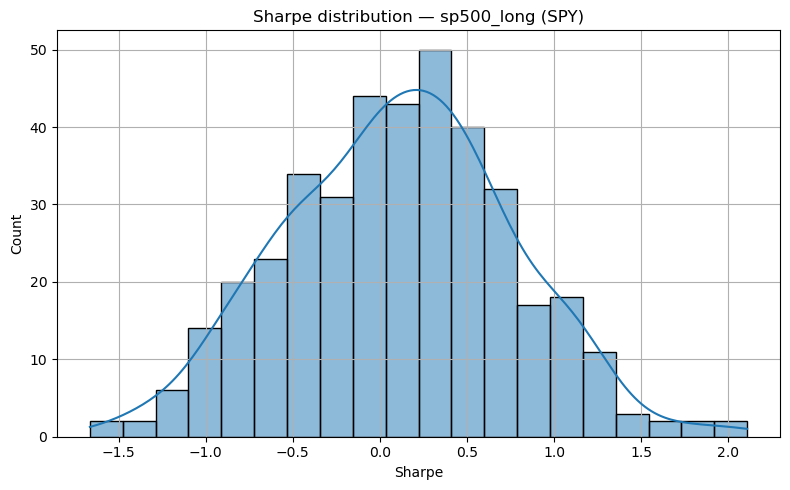

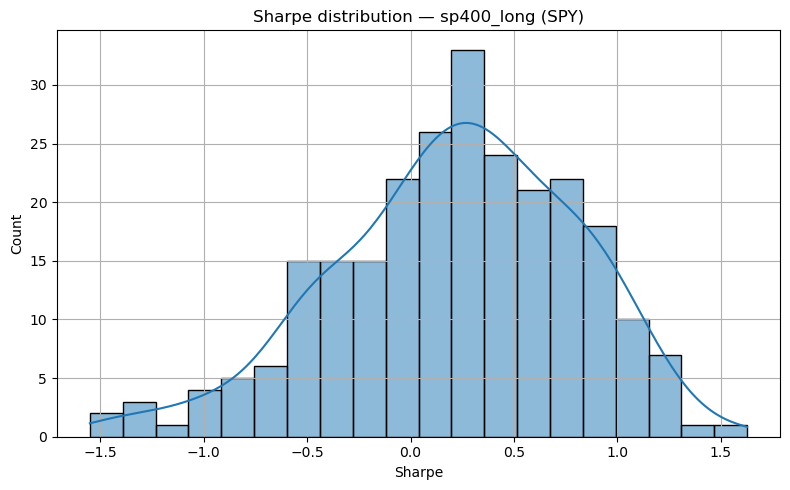

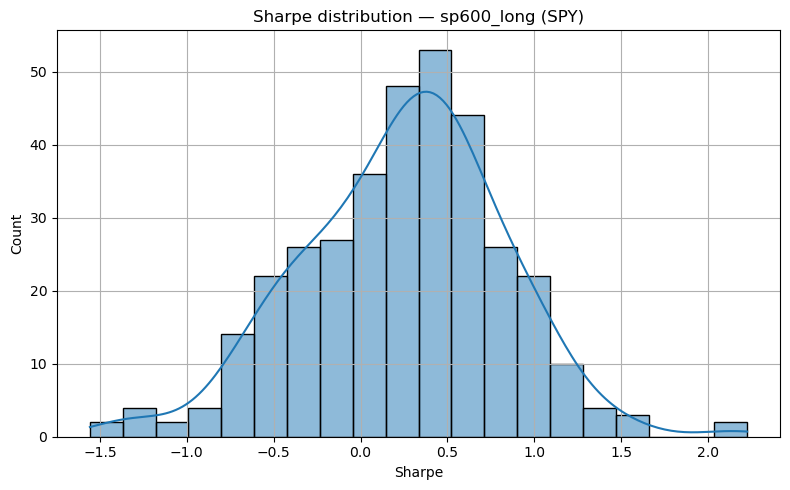

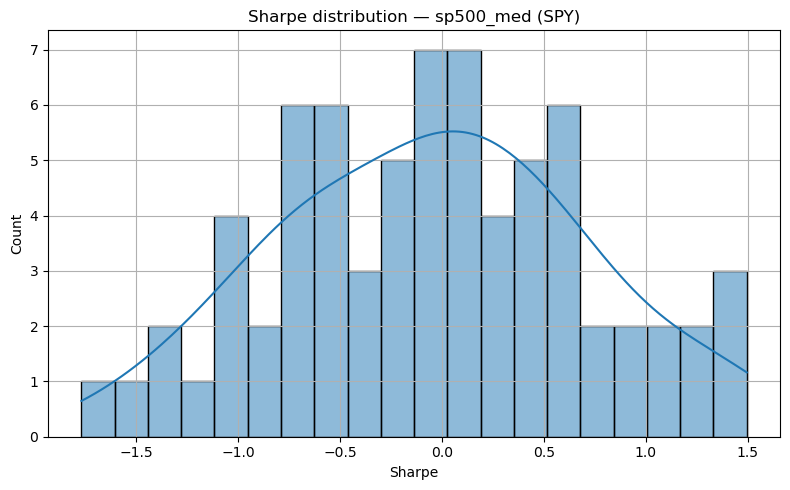

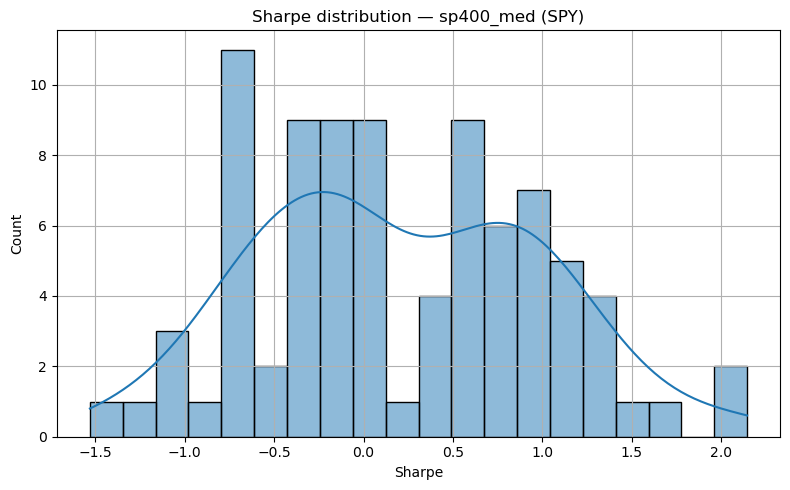

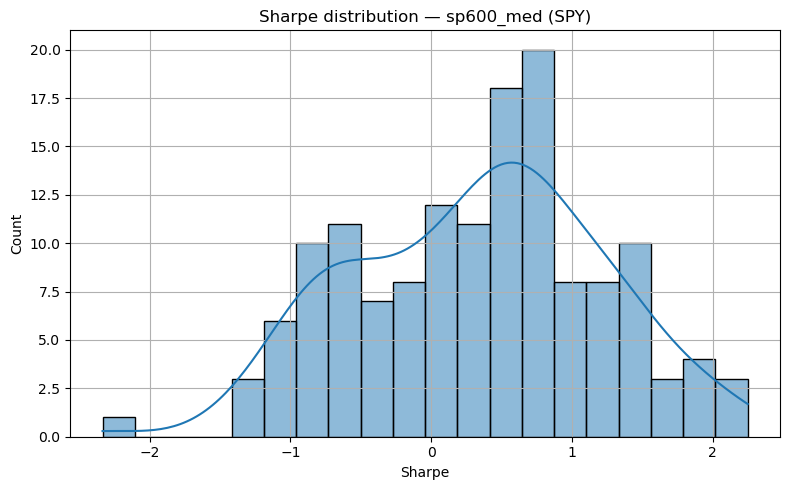

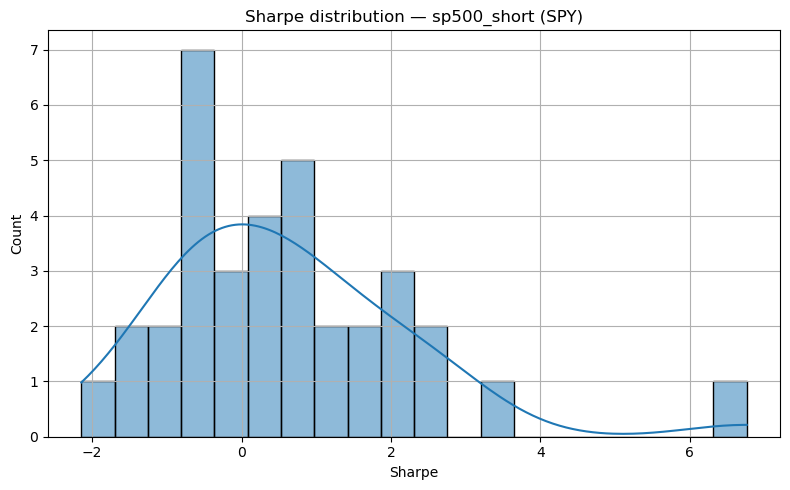

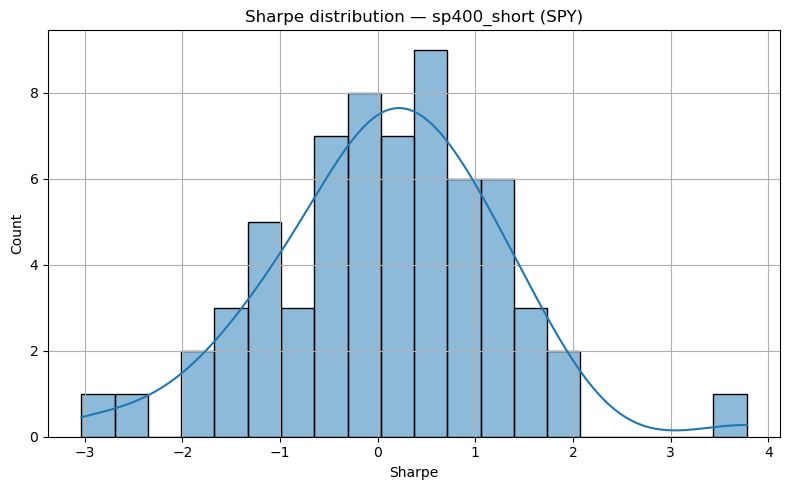

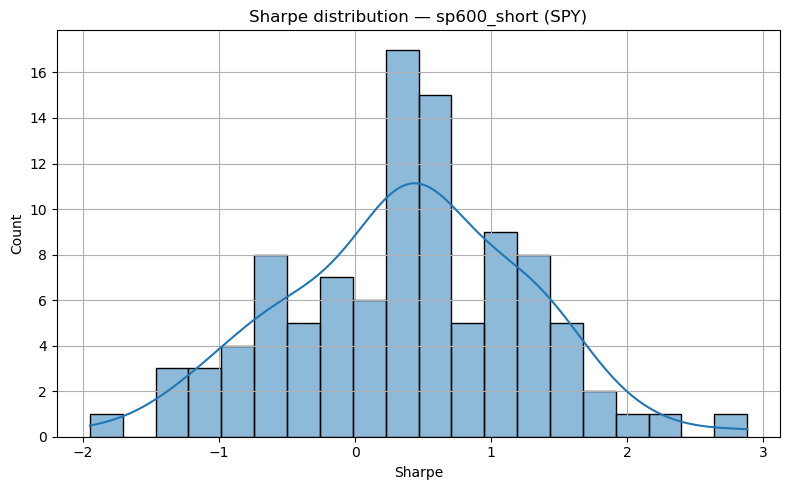

Running ONE-DAY batch on 18 dates from 2024-04-03 to 2025-10-03
[sp500_long / SPY] N_dates=18 | Mean NetPnL=-0.00301 | Median NetPnL=0.00000 | Hit=59.72% | NonFlatHit=44.42%
[sp500_long / QQQ] N_dates=18 | Mean NetPnL=-0.00237 | Median NetPnL=0.00000 | Hit=62.04% | NonFlatHit=47.76%
[sp400_long / SPY] N_dates=18 | Mean NetPnL=-0.00683 | Median NetPnL=-0.00000 | Hit=56.35% | NonFlatHit=39.01%
[sp400_long / QQQ] N_dates=18 | Mean NetPnL=-0.00544 | Median NetPnL=0.00000 | Hit=59.14% | NonFlatHit=41.73%
[sp600_long / SPY] N_dates=18 | Mean NetPnL=-0.00812 | Median NetPnL=0.00000 | Hit=56.84% | NonFlatHit=38.18%
[sp600_long / QQQ] N_dates=18 | Mean NetPnL=-0.00687 | Median NetPnL=0.00000 | Hit=58.50% | NonFlatHit=39.53%
[sp500_med / SPY] N_dates=18 | Mean NetPnL=-0.00303 | Median NetPnL=0.00000 | Hit=62.99% | NonFlatHit=44.83%
[sp500_med / QQQ] N_dates=18 | Mean NetPnL=-0.00202 | Median NetPnL=-0.00000 | Hit=65.49% | NonFlatHit=45.34%
[sp400_med / SPY] N_dates=18 | Mean NetPnL=-0.00481 | Me

,MeanNetPnL,MedianNetPnL,Trades,Dates,NonFlatHit
Ticker,,,,,
DECK,0.012096,0.007241,17,18,0.647059
IT,0.011361,0.000000,7,18,1.000000
BDX,0.010444,0.000000,8,18,0.625000
CVS,0.009593,0.007981,18,18,0.611111
SWKS,0.007594,0.000983,16,18,0.625000
ERIE,0.007315,0.000000,7,18,0.857143
DXCM,0.006002,0.000000,8,18,0.750000
HUM,0.005976,0.000000,16,18,0.562500
WBD,0.005855,-0.000000,16,18,0.500000


In [21]:
def log(msg):
    print(f"[{datetime.now(ZoneInfo('America/Los_Angeles')):%Y-%m-%d %H:%M:%S}] {msg}", flush=True)

# Stock universe groupings / scenarios based on market cap and price history available
scenarios = {
    # Long history
    "sp500_long": {"tickers": b500["long"], "start": "2000-01-01"},
    "sp400_long": {"tickers": b400["long"], "start": "2000-01-01"},
    "sp600_long": {"tickers": b600["long"], "start": "2000-01-01"},
    # Medium history
    "sp500_med":  {"tickers": b500["medium"], "start": "2005-01-01"},
    "sp400_med":  {"tickers": b400["medium"], "start": "2005-01-01"},
    "sp600_med":  {"tickers": b600["medium"], "start": "2005-01-01"},
    # Short history
    "sp500_short":{"tickers": b500["short"], "start": "2016-01-01"},
    "sp400_short":{"tickers": b400["short"], "start": "2016-01-01"},
    "sp600_short":{"tickers": b600["short"], "start": "2016-01-01"},
}

# Warm cache once top speed up subsequent runs
all_tickers = set().union(*[set(cfg["tickers"]) for cfg in scenarios.values()])
required = all_tickers | {MARKET_DEFAULT, MARKET_ALT, SIZE_MID, SIZE_SML} | set(SECTOR_ETFS) | set(MACROS)
_ = ensure_prices_cache(required, start="1999-01-01", end=None)


# ============================================================
# Run classic 80/20 experiments for all scenarios
# ============================================================

log("Running 80/20 experiments for all scenarios …")
exp_results = {}
for name, cfg in scenarios.items():
    log(f"=== {name} ===")
    exp_results[name] = experiment(name, cfg["tickers"], start=cfg["start"])

# Consolidate per-ticker results across all scenarios (for quick ranking)
rows = []
for name, res in exp_results.items():
    for suite in ("SPY","QQQ"):
        df = res.get(suite, {}).get("df", None)
        if df is not None and not df.empty:
            d = df.copy()
            d["Scenario"] = name
            d["Suite"] = suite
            rows.append(d)
exp_all = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

SUM_DIR = RESULTS_DIR / "_summaries"; SUM_DIR.mkdir(parents=True, exist_ok=True)
if not exp_all.empty:
    exp_all.sort_values(["Suite","Scenario","Sharpe"], ascending=[True, True, False]) \
           .to_csv(SUM_DIR / "exp_all_metrics.csv", index=False)
    display(exp_all.query("Suite=='SPY'").sort_values("Sharpe", ascending=False).head(10))

# Plot Sharpe histograms by scenario (SPY only, quick view)
def plot_sharpe_hist_for(name):
    df = exp_results[name]["SPY"]["df"]
    if df is None or df.empty:
        print(f"[INFO] no SPY table for {name}."); return
    plt.figure(figsize=(8,5))
    sns.histplot(df["Sharpe"].replace([np.inf,-np.inf], np.nan).dropna(), bins=20, kde=True)
    plt.title(f"Sharpe distribution — {name} (SPY)")
    plt.xlabel("Sharpe")
    plt.tight_layout(); plt.show()

for nm in scenarios.keys():
    plot_sharpe_hist_for(nm)


# ============================================================
# Run One-Day Holdout across many dates for each scenario
# ============================================================

try:
    _cache, _ = _load_cache()
    _end = (_cache.index.max() if not _cache.empty else pd.Timestamp.today().normalize())
except Exception:
    _end = pd.Timestamp.today().normalize()
_start = (_end - pd.DateOffset(months=18)).strftime("%Y-%m-%d")
_end_s = _end.strftime("%Y-%m-%d")
dates_bm = business_month_end_dates(_start, _end_s)
print(f"Running ONE-DAY batch on {len(dates_bm)} dates from {_start} to {_end_s}")

one_day_results = {}
for name, cfg in scenarios.items():
    # suites=("SPY","QQQ") to compare hedges; use ("SPY",) if you only want SPY
    one_day_results[name] = run_one_day_batch(name, cfg["tickers"], dates_bm, start=cfg["start"], suites=("SPY","QQQ"))

# Quick portfolio summaries
def summarize_port(res, label):
    df = res["port"]
    if df.empty:
        print(f"[{label}] no portfolio rows."); return
    for suite in ("SPY","QQQ"):
        g = df[df["Suite"]==suite]
        if g.empty: continue
        print(f"[{label} / {suite}] N_dates={len(g)} | "
              f"Mean NetPnL={g['MeanNetPnL'].mean():.5f} | "
              f"Median NetPnL={g['MedianNetPnL'].median():.5f} | "
              f"Hit={g['HitRate'].mean():.2%} | "
              f"NonFlatHit={g['NonFlatHitRate'].mean():.2%}")

for name, res in one_day_results.items():
    summarize_port(res, name)

# Per-ticker ranking for e.g. SPY in sp500_long across all one-day dates
def rank_tickers(res, suite="SPY"):
    rows = res["rows"]
    if rows.empty: return pd.DataFrame()
    r = rows[rows["Suite"]==suite].copy()
    grp = r.groupby("Ticker").agg(
        MeanNetPnL=("NetPnL","mean"),
        MedianNetPnL=("NetPnL","median"),
        Trades=("Decision", lambda s: int((s!=0).sum())),
        Dates=("Date","nunique"),
    )
    rf = r[r["Decision"]!=0].copy()
    nf = rf.groupby("Ticker").apply(lambda g: (np.sign(g["ExcessRetNext"])==g["Decision"]).mean()).rename("NonFlatHit")
    grp = grp.join(nf, how="left")
    return grp.sort_values(["MeanNetPnL","MedianNetPnL"], ascending=False)

display(rank_tickers(one_day_results["sp500_long"], suite="SPY").head(15)) 